## Flowers Recognition 

The Oxford Flowers 102 dataset is a collection of 102 flower categories commonly occurring in the United 
Kingdom. Each class consists of between 40 and 258 images. The images have large scale, pose and light 
variations. In addition, there are categories that have large variations within the category and several very 
similar categories. 
The dataset is divided into a training set, a validation set and a test set. The training set and validation set 
each consist of 10 images per class (a total of 1020 images each). The test set consists of the remaining 
6149 images (minimum 20 per class). Some tasks to consider: 
1. Modify some previously published architectures e.g., increase the network depth, reducing their 
parameters,  etc.  Explore  more  advanced  techniques  such  as  deformable  convolution,  dilated 
convolution (dilation>1) or visual prompt tuning for Transformers. 
2. Analyze the results of using fewer training images, i.e., few-shot learning 
3. Use  more  advanced  transformation  techniques  such  as  MixUp  (see  the  original  paper  and  its 
PyTorch implementation here) 
4. Try more advanced loss function such as triplet loss

## Purpose
This notebook is for experimenting with how base pre trained models handle the dataset without any modifications, before other improvements are made.

In [18]:
import platform

if platform.system() == "Darwin":  # macOS
    %pip install -r requirements_mac.txt
else:
    %pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.


## Environment Setup

This section setups the environment by doing the following:
1. Importing the dependencies
2. Checking if CUDA/mps is available on device running this notebook
3. Setting up data and output folder to store downloaded dataset and outputs
4. Setting up of transforms for data augmentation
5. Downloading of datasets after transforms are initialized
6. Setting up of hyper parameters for training
7. Creation of dataloaders and visualizing data

### 1. Importing the dependencies

In [19]:
# Import necessary libraries
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
import scipy.io as scp
import random

# Torch dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchsummary import summary  # For model architecture visualization

### 2. Checking if CUDA/mps is available

In [20]:
# Set the device based on availability of MPS (macOS), CUDA, or CPU
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 3. Setting up data and output folders to store downloaded dataset and output later on

In [21]:
# Define the data directories to store dataset and outputs
data_dir = "./data"
output_dir = "./output" 

# Create directories if they do not exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

### 4. Image Transforms and Augmentation
In the training transform, it is normalized to those values instead of (0.5, 0.5, 0.5) for both std and mean as it is common practice and was calculated based on millions of images. So we will try that for now.

Ref: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2

In [22]:
# Handle data transformations and augmentation for training, validation and testing
# Make a standard coefficient for all parameters of color jitter
jitter_coefficient = 0.1
normalize_std = [0.485, 0.456, 0.406]
normalize_mean = [0.229, 0.224, 0.225]

# For our training data, we will apply data augmentation to improve generalization and help the model become more robust to different variations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), # Crop at random position and resizes
    transforms.RandomHorizontalFlip(), # This randomly flips images horizontally
    # transforms.RandomRotation(20), # Randomly rotates the image within +- 20 degrees
    transforms.ColorJitter(brightness=jitter_coefficient, contrast=jitter_coefficient, saturation=jitter_coefficient, hue=jitter_coefficient), # Randomly changes brightness, contrast, saturation and hue
    transforms.ToTensor(), # Converts the image to a PyTorch tensor
    transforms.Normalize(std=normalize_std, mean=normalize_mean) # Normalizes the image with mean and std deviation (from ImageNet)
])

# For validation and testing data, we should only resize and normalize to ensure consistent results
val_test_transforms = transforms.Compose([
    transforms.Resize(256), # Resizes the image to 256x256
    transforms.CenterCrop(224), # Resizes the image to 224x224
    transforms.ToTensor(), # Converts the image to a PyTorch tensor
    transforms.Normalize(std=normalize_std, mean=normalize_mean) # Normalizes the image with mean and std deviation (from ImageNet)
])

### 5. Dataset Downloading
- Load the Oxford Flowers 102 dataset which is split into the following:
  - Training : 10 image per class (1020 images)
  - Validation : 10 image per class (1020 images)
  - Test set : remaining images (6149 images)

In [26]:
# Then download the data from source and store into the data directory
train_dataset = datasets.Flowers102(root = data_dir, split='train', transform=train_transforms, download=True)
val_dataset = datasets.Flowers102(root = data_dir, split='val', transform=val_test_transforms, download=True)
test_dataset = datasets.Flowers102(root = data_dir, split='test', transform=val_test_transforms, download=True)

# Print dataset sizes
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Acquire their label datas
label_data =scp.loadmat(os.path.join(data_dir, 'flowers-102', 'imagelabels.mat'))
labels = label_data['labels']
display(labels)

Train set size: 1020
Validation set size: 1020
Test set size: 6149


array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)

### 6. Hyperparameters Setup

In [7]:
# Hyperparameters setup
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
AVAILABLE_MODELS = ['resnet50', 'vgg16', 'densenet121']  # Add more models as needed
MODEL = AVAILABLE_MODELS[0] # Other options include 'vgg16', 'densenet121', etc.
NUM_CLASSES = 102 # Number of classes in the dataset, Oxford 102 has 102 classes 

### 7. Creation of dataloaders and visualizing data

In [ ]:
# Create our dataloaders for batching and iterators
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Store our dataloaders in a dictionary for easy access
data_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}
# Store our dataset sizes in a dictionary for easy access
dataset_sizes = {
    'train': len(train_loader.dataset),
    'val': len(val_loader.dataset),
    'test': len(test_loader.dataset)
}

In [9]:
def visualize_dataset_samples(dataset, class_names, num_samples=5):
    """
    Visualize sample images from the dataset with better color preservation
    """
    # Create a DataLoader with batch_size=1
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Get raw samples before normalization
    # First, save the original transform
    original_transform = dataset.transform
    
    # Temporarily remove normalization for visualization
    dataset.transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor()  # Only convert to tensor, no normalization
    ])
    
    # Create a new loader with the modified transform
    raw_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Get samples (both normalized and raw)
    samples = []
    raw_samples = []
    labels = []
    
    # Use the same random seed for both loaders to get same images
    torch.manual_seed(42)
    for i, (img, label) in enumerate(loader):
        if i >= num_samples:
            break
        samples.append(img[0])
        labels.append(label.item())
    
    torch.manual_seed(42)
    for i, (img, _) in enumerate(raw_loader):
        if i >= num_samples:
            break
        raw_samples.append(img[0])
    
    # Restore the original transform
    dataset.transform = original_transform
    
    # Plot samples side by side (normalized vs. raw)
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i, (norm_img, raw_img, label) in enumerate(zip(samples, raw_samples, labels)):
        # Denormalize the normalized image
        norm_img = norm_img.cpu().numpy().transpose((1, 2, 0))
        mean = np.array(normalize_mean) # This is same value as the one used in normalization
        std = np.array(normalize_std)
        denorm_img = std * norm_img + mean
        denorm_img = np.clip(denorm_img, 0, 1)
        
        # Convert raw image to numpy
        raw_img = raw_img.cpu().numpy().transpose((1, 2, 0))
        
        # Plot denormalized image
        axes[0, i].imshow(denorm_img)
        axes[0, i].set_title(f"Denormalized")
        axes[0, i].axis('off')
        
        # Plot raw image
        axes[1, i].imshow(raw_img)
        axes[1, i].set_title(f"Original: {class_names[label]}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

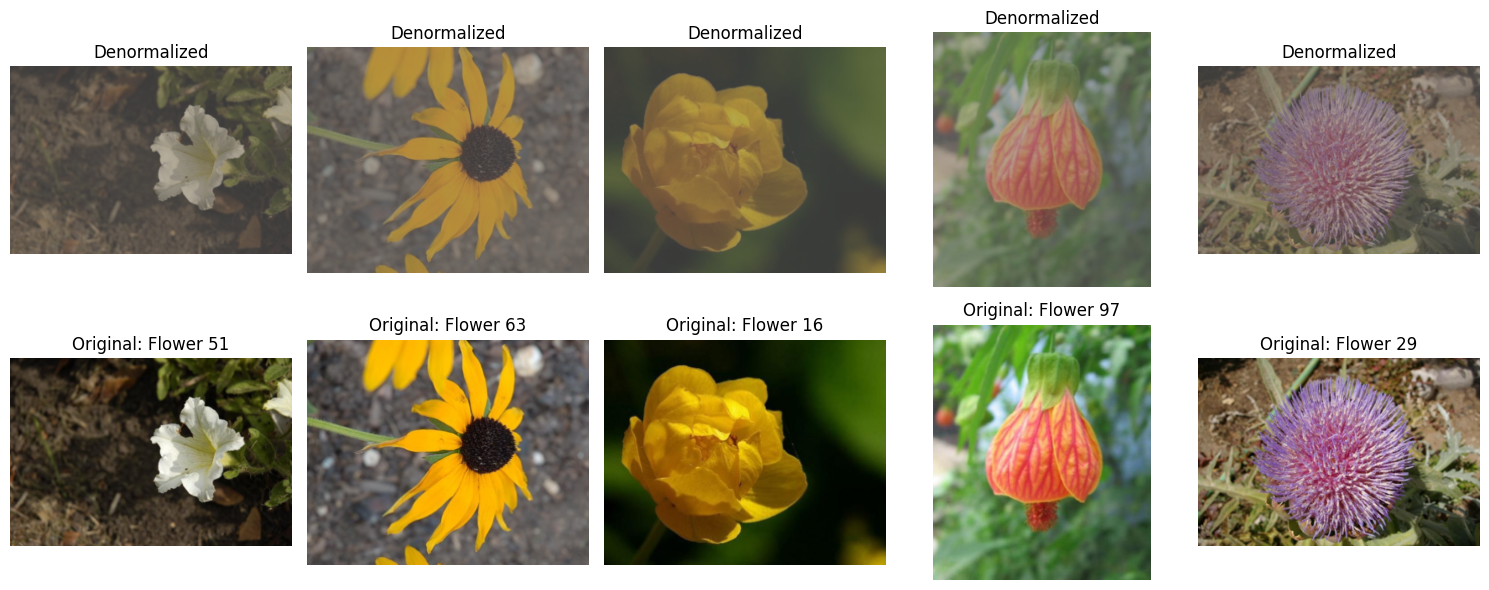

In [10]:
# Visualize training samples
# Generate class names (flower categories 1-102)
class_names = [f"Flower {i+1}" for i in range(NUM_CLASSES)]
# Using a separate dataset with non-augmented transforms for clearer visualization
visualization_dataset = datasets.Flowers102(
    root=data_dir,
    split='train',
    download=False,  # Already downloaded above
    transform=val_test_transforms  # Using non-augmented transforms for visualization
)

visualize_dataset_samples(visualization_dataset, class_names, num_samples=5)

In [11]:
class BaselineModel:
    """
    Class for the baseline model using a pretrained architecture
    """
    def __init__(self, num_classes, model_name='resnet50'):
        self.num_classes = num_classes
        self.model_name = model_name
        
        # Initialize the model
        self.model = self._initialize_model()
        self.model = self.model.to(device)  # Move to GPU if available
        
        # Set loss function - Cross Entropy is standard for classification
        self.criterion = nn.CrossEntropyLoss()
    
    def _initialize_model(self):
        """
        Initialize a pretrained model without any modifications
        """
        # For this baseline, we'll use ResNet50 without any modifications
        # You can replace this with other architectures like VGG, DenseNet, EfficientNet, etc.
        if self.model_name == 'resnet50':
            model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            # Replace the final fully connected layer
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, self.num_classes)
        
        elif self.model_name == 'vgg16':
            model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
            # Replace the final classifier
            num_ftrs = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(num_ftrs, self.num_classes)
        
        elif self.model_name == 'densenet121':
            model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
            # Replace the final classifier
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(num_ftrs, self.num_classes)
            
        return model
    
    def set_optimizer(self, lr=0.001):
        """
        Set the optimizer for training
        """
        # Using SGD with momentum - reliable optimizer for many computer vision tasks
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        
        # Learning rate scheduler - reduce learning rate when validation loss plateaus
        self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', 
                                                      factor=0.1, patience=5, verbose=True)
        
    def train_model(self, data_loaders, dataset_sizes, num_epochs=25, save_path=None):
        """
        Train the model
        """
        # Track best model weights
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        
        # Track training history
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
        
        # Track the time
        start_time = time.time()
        
        # Training loop
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()  # Set model to training mode
                else:
                    self.model.eval()   # Set model to evaluate mode
                
                running_loss = 0.0
                running_corrects = 0
                
                # Iterate over data
                for inputs, labels in tqdm(data_loaders[phase], desc=phase):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Zero the parameter gradients
                    self.optimizer.zero_grad()
                    
                    # Forward pass - track history only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = self.criterion(outputs, labels)
                        
                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                # Calculate epoch loss and accuracy
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Store history
                if phase == 'train':
                    history['train_loss'].append(epoch_loss)
                    history['train_acc'].append(epoch_acc.item())
                else:
                    history['val_loss'].append(epoch_loss)
                    history['val_acc'].append(epoch_acc.item())
                    # Update scheduler based on validation loss
                    self.scheduler.step(epoch_loss)
                
                # Save best model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    if save_path:
                        torch.save(self.model.state_dict(), save_path)
            
            print()
        
        # Report training time
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        
        return history
    
    def evaluate_model(self, data_loader):
        """
        Evaluate the model on the test set
        """
        self.model.eval()
        
        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []
        
        # No gradient computation needed for evaluation
        with torch.no_grad():
            for inputs, labels in tqdm(data_loader, desc='Testing'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = self.criterion(outputs, labels)
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Store predictions and labels for further analysis
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate test loss and accuracy
        dataset_size = len(data_loader.dataset)
        test_loss = running_loss / dataset_size
        test_acc = running_corrects.float() / dataset_size
        
        print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
        
        return test_loss, test_acc, all_preds, all_labels
    
    def save_model(self, path):
        """
        Save the model to disk
        """
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, path)
        
    def load_model(self, path):
        """
        Load a saved model from disk
        """
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [12]:
def plot_training_history(history, save_path=None):
    """
    Plot training and validation loss and accuracy
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

In [13]:
model = BaselineModel(num_classes=NUM_CLASSES, model_name=MODEL)

# Display model architecture summary
print(f"\nModel Architecture: {MODEL}")
if torch.cuda.is_available():
    summary(model.model, (3, 224, 224), device=device.type)
else:
    print("CUDA not available for model summary visualization.")

# Configure optimizer
model.set_optimizer(lr=LEARNING_RATE)


Model Architecture: resnet50
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      Bat

c:\Users\isaac\Documents\GitHub\flowers-recognition\.venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
model_save_path = os.path.join(output_dir, f'{MODEL}_baseline.pth')
history = model.train_model(data_loaders, dataset_sizes, NUM_EPOCHS, model_save_path)

Epoch 1/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.6449 Acc: 0.0147


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 4.4307 Acc: 0.0863

Epoch 2/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.3545 Acc: 0.1176


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 4.0961 Acc: 0.3196

Epoch 3/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.0107 Acc: 0.3363


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.6745 Acc: 0.5235

Epoch 4/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.6041 Acc: 0.5078


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.2011 Acc: 0.6284

Epoch 5/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.2183 Acc: 0.5794


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.8109 Acc: 0.6922

Epoch 6/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.7812 Acc: 0.6716


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.3306 Acc: 0.7304

Epoch 7/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.4594 Acc: 0.7000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.0540 Acc: 0.7549

Epoch 8/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.1232 Acc: 0.7412


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.7759 Acc: 0.7980

Epoch 9/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.8677 Acc: 0.7853


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.5276 Acc: 0.8363

Epoch 10/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.6235 Acc: 0.7912


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.3031 Acc: 0.8686

Epoch 11/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.4696 Acc: 0.8088


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.1299 Acc: 0.8706

Epoch 12/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.2842 Acc: 0.8520


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.0047 Acc: 0.8873

Epoch 13/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.1099 Acc: 0.8637


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.8276 Acc: 0.9118

Epoch 14/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.0054 Acc: 0.8735


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.7174 Acc: 0.9324

Epoch 15/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.8484 Acc: 0.9088


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.6505 Acc: 0.9245

Epoch 16/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.8128 Acc: 0.9196


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5636 Acc: 0.9324

Epoch 17/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.6875 Acc: 0.9275


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5115 Acc: 0.9402

Epoch 18/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.6400 Acc: 0.9137


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.4714 Acc: 0.9431

Epoch 19/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.5971 Acc: 0.9265


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.4428 Acc: 0.9422

Epoch 20/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.5601 Acc: 0.9265


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.3787 Acc: 0.9539

Epoch 21/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.4936 Acc: 0.9422


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.3580 Acc: 0.9559

Epoch 22/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.4682 Acc: 0.9461


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.3126 Acc: 0.9657

Epoch 23/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.4494 Acc: 0.9490


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.3420 Acc: 0.9529

Epoch 24/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.4229 Acc: 0.9461


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.2421 Acc: 0.9716

Epoch 25/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.3862 Acc: 0.9431


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.2631 Acc: 0.9657

Training complete in 6m 45s
Best val Acc: 0.9716


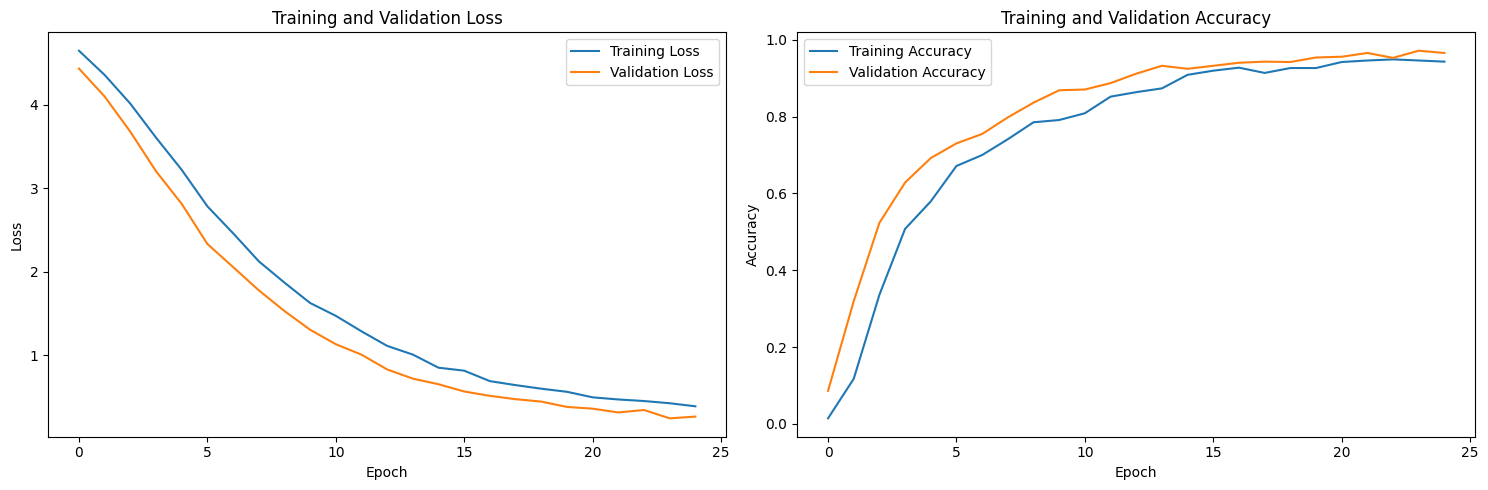

Testing:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 0.2594 Acc: 0.9745
Final Test Accuracy: 0.9745

Model Parameter Information:
Total parameters: 23,717,030
Trainable parameters: 23,717,030
Non-trainable parameters: 0


In [15]:
# Plot training history
plot_training_history(history)

# Evaluate on test set
test_loss, test_acc, all_preds, all_labels = model.evaluate_model(data_loaders['test'])

# Print final results
print(f"Final Test Accuracy: {test_acc:.4f}")

# Calculate and print parameter count
total_params = sum(p.numel() for p in model.model.parameters())
trainable_params = sum(p.numel() for p in model.model.parameters() if p.requires_grad)

print(f"\nModel Parameter Information:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")

# Save complete model (including optimizer state)
model_checkpoint_path = os.path.join(output_dir, f'{MODEL}_baseline_checkpoint.pth')
model.save_model(model_checkpoint_path)

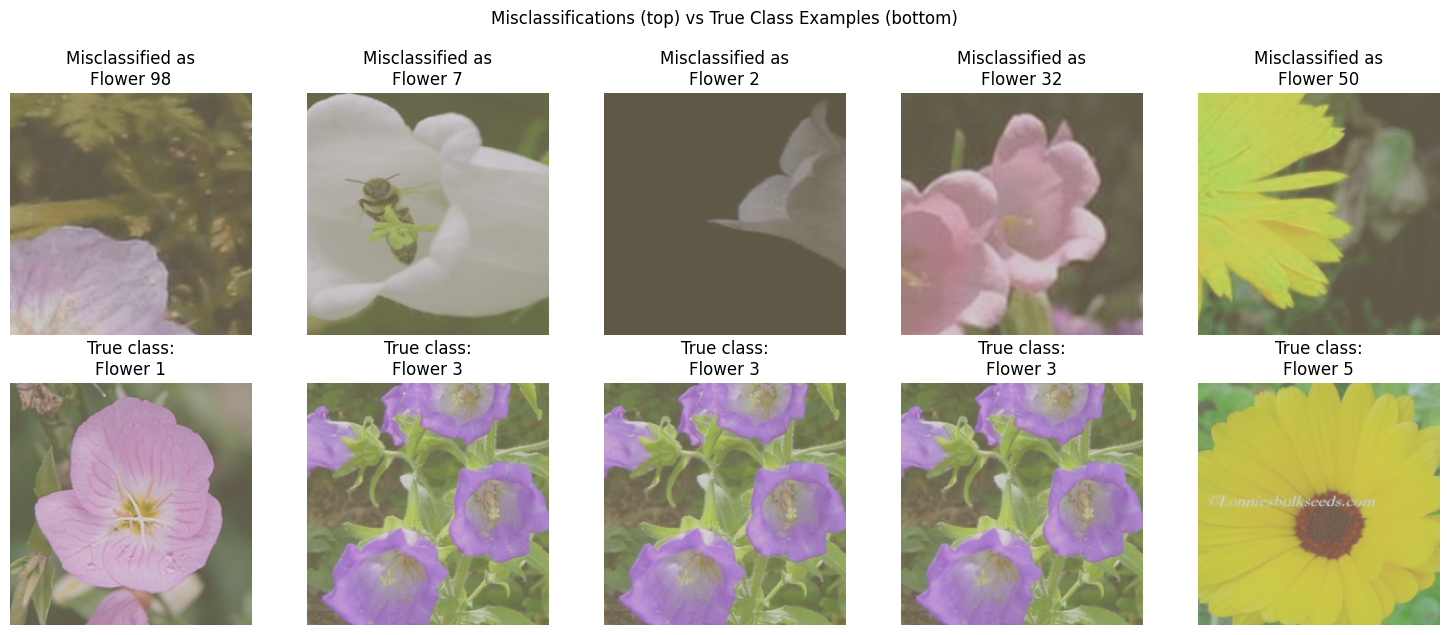

In [16]:
def visualize_misclassifications(model, data_loader, class_names, dataset, num_samples=5):
    """
    Find and visualize misclassified images, along with examples of the correct class
    
    Args:
        model: The model to evaluate
        data_loader: DataLoader containing test images
        class_names: List of class names
        dataset: The full dataset to find examples from true classes
        num_samples: Number of misclassifications to display
    """
    model.model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    
    # Find misclassified images
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model.model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for i in range(len(inputs)):
                if preds[i] != labels[i]:
                    misclassified_images.append(inputs[i].cpu())
                    misclassified_labels.append(labels[i].item())
                    misclassified_preds.append(preds[i].item())
                    
                    if len(misclassified_images) >= num_samples:
                        break
            
            if len(misclassified_images) >= num_samples:
                break
    
    # If we didn't find any misclassifications, return
    if not misclassified_images:
        print("No misclassifications found in the batches checked")
        return
    
    # Create separate DataLoaders for each class of interest to find examples
    class_examples = {}
    
    # For each true label of a misclassified image
    for true_label in set(misclassified_labels):
        # Find an example of this class in the dataset
        for idx in range(len(dataset)):
            _, label = dataset[idx]
            if label == true_label:
                # Get the image with the same transformation as test images
                img_tensor, _ = dataset[idx]
                class_examples[true_label] = img_tensor
                break
    
    # Plot misclassified images and their true class examples
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i, (wrong_img, true_label, pred_label) in enumerate(zip(misclassified_images, misclassified_labels, misclassified_preds)):
        if i >= num_samples:
            break
            
        # Get example of the true class
        true_class_example = class_examples.get(true_label, wrong_img)  # Fallback to the wrong image if no example found
        
        # Denormalize misclassified image
        wrong_img = wrong_img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        wrong_img = std * wrong_img + mean
        wrong_img = np.clip(wrong_img, 0, 1)
        
        # Denormalize true class example
        true_example = true_class_example.numpy().transpose((1, 2, 0))
        true_example = std * true_example + mean
        true_example = np.clip(true_example, 0, 1)
        
        # Plot misclassified image
        axes[0, i].imshow(wrong_img)
        axes[0, i].set_title(f"Misclassified as\n{class_names[pred_label]}")
        axes[0, i].axis('off')
        
        # Plot true class example
        axes[1, i].imshow(true_example)
        axes[1, i].set_title(f"True class:\n{class_names[true_label]}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.suptitle("Misclassifications (top) vs True Class Examples (bottom)", y=1.05)
    plt.show()

visualize_misclassifications(model, data_loaders['test'], class_names, test_dataset)

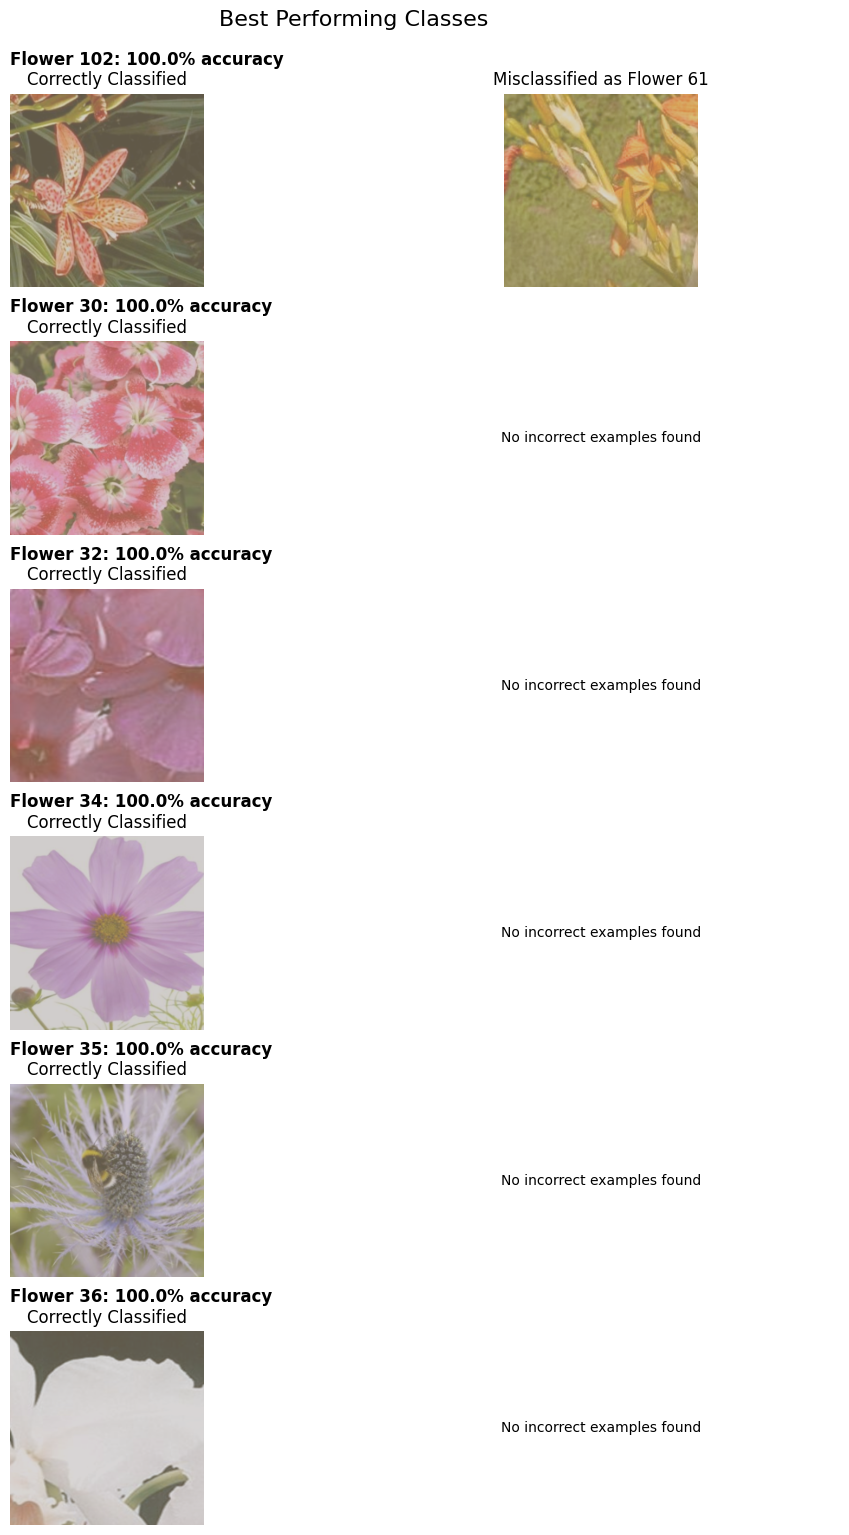

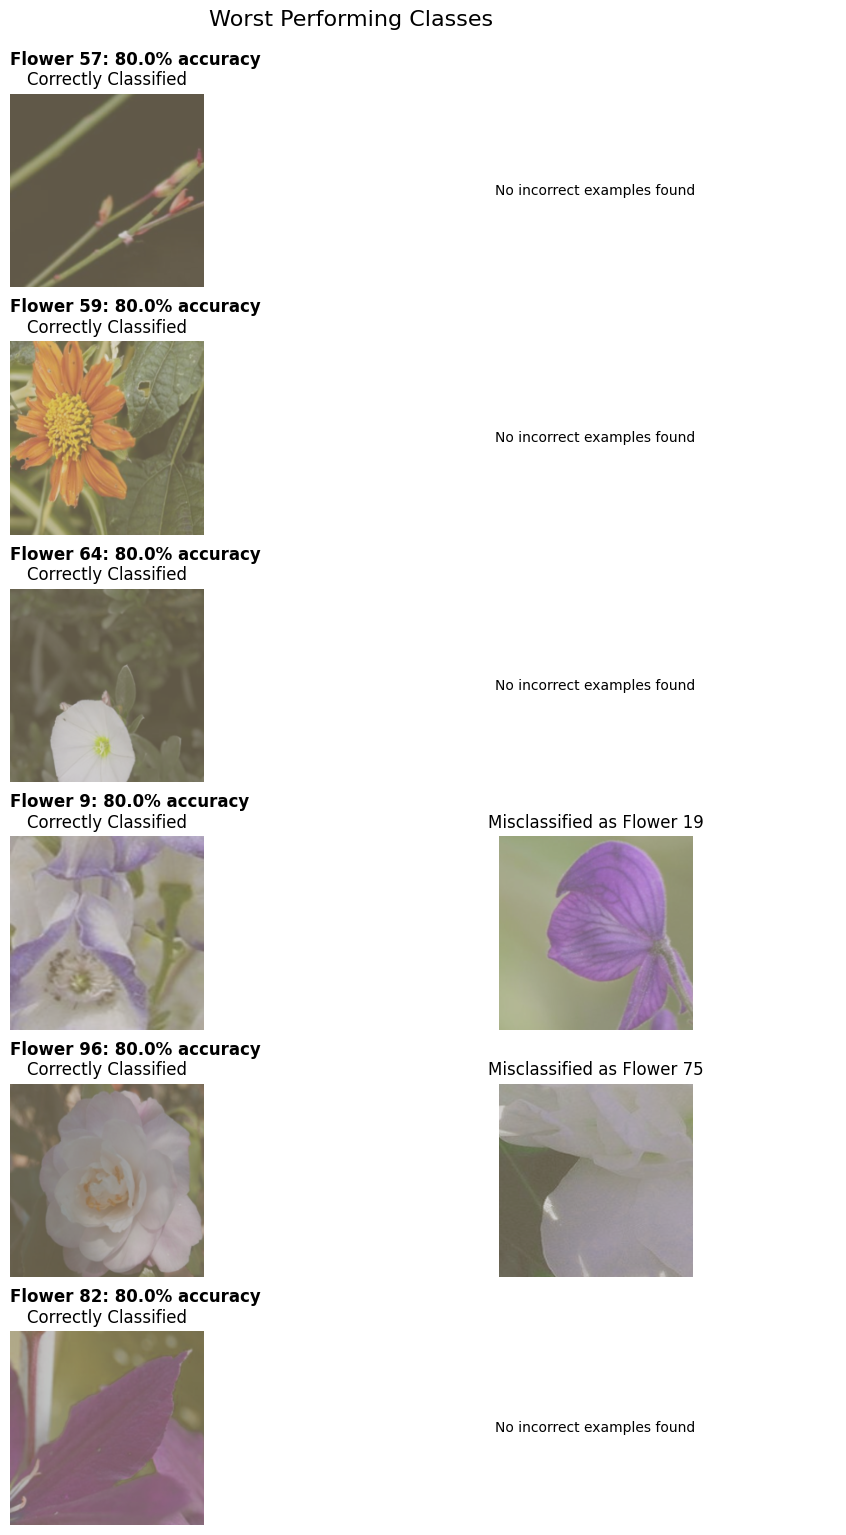

Overall Model Accuracy: 95.98%
Best Class: Flower 102 (100.00%)
Worst Class: Flower 57 (80.00%)


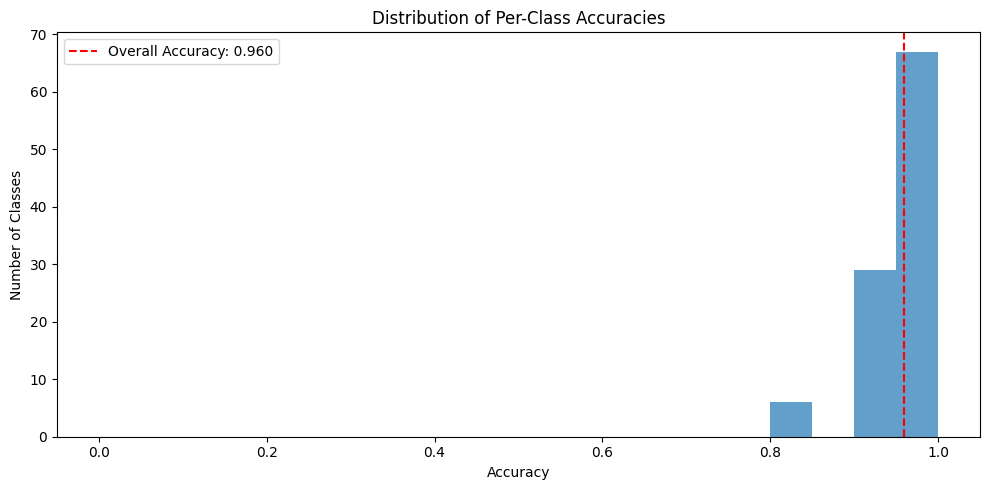

In [17]:
def visualize_classification_performance(model, data_loader, class_names, num_classes=6, num_per_class=2):
    """
    Visualize both correctly and incorrectly classified examples from the test set
    
    Args:
        model: The trained model to evaluate
        data_loader: DataLoader for the test dataset
        class_names: List of class names
        num_classes: Number of classes to display (default: 6)
        num_per_class: Number of examples to show per class (1 correct, 1 incorrect) (default: 2)
    """
    model.model.eval()
    
    # Initialize containers for examples
    correct_examples = {i: [] for i in range(len(class_names))}
    incorrect_examples = {i: [] for i in range(len(class_names))}
    
    # Collect examples
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model.model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Check each example in the batch
            for i in range(len(inputs)):
                true_label = labels[i].item()
                pred_label = preds[i].item()
                
                # Store the example in the appropriate container
                if pred_label == true_label:
                    if len(correct_examples[true_label]) < num_per_class:
                        correct_examples[true_label].append(inputs[i].cpu())
                else:
                    # For incorrect classifications, store with both true and predicted labels
                    if len(incorrect_examples[true_label]) < num_per_class:
                        incorrect_examples[true_label].append((inputs[i].cpu(), pred_label))
    
    # Calculate per-class accuracy for all classes
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model.model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy for each class
    class_correct = np.zeros(len(class_names))
    class_total = np.zeros(len(class_names))
    
    for i in range(len(all_labels)):
        label = all_labels[i]
        class_total[label] += 1
        if all_preds[i] == label:
            class_correct[label] += 1
    
    class_accuracy = np.zeros(len(class_names))
    for i in range(len(class_names)):
        if class_total[i] > 0:
            class_accuracy[i] = class_correct[i] / class_total[i]
    
    # Get the top and bottom performing classes
    sorted_class_indices = np.argsort(class_accuracy)
    top_classes = sorted_class_indices[-num_classes:][::-1]  # Best performing classes
    bottom_classes = sorted_class_indices[:num_classes]      # Worst performing classes
    
    # Function to denormalize images
    def denormalize(img_tensor):
        img = img_tensor.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        return np.clip(img, 0, 1)
    
    # Function to display examples for a given set of classes
    def plot_class_examples(classes, title):
        fig, axes = plt.subplots(len(classes), 2, figsize=(10, len(classes)*2.5))
        
        for idx, class_idx in enumerate(classes):
            # Display class name and accuracy
            accuracy = class_accuracy[class_idx] * 100
            axes[idx, 0].text(0, 1.15, f"{class_names[class_idx]}: {accuracy:.1f}% accuracy", 
                             transform=axes[idx, 0].transAxes, fontsize=12, fontweight='bold')
            
            # Display a correctly classified example if available
            if correct_examples[class_idx]:
                correct_img = denormalize(correct_examples[class_idx][0])
                axes[idx, 0].imshow(correct_img)
                axes[idx, 0].set_title("Correctly Classified")
                axes[idx, 0].axis('off')
            else:
                axes[idx, 0].text(0.5, 0.5, "No correct examples found", 
                                 ha='center', va='center', transform=axes[idx, 0].transAxes)
                axes[idx, 0].axis('off')
            
            # Display an incorrectly classified example if available
            if incorrect_examples[class_idx]:
                incorrect_img, pred_label = incorrect_examples[class_idx][0]
                incorrect_img = denormalize(incorrect_img)
                axes[idx, 1].imshow(incorrect_img)
                axes[idx, 1].set_title(f"Misclassified as {class_names[pred_label]}")
                axes[idx, 1].axis('off')
            else:
                axes[idx, 1].text(0.5, 0.5, "No incorrect examples found", 
                                 ha='center', va='center', transform=axes[idx, 1].transAxes)
                axes[idx, 1].axis('off')
        
        plt.tight_layout()
        plt.suptitle(title, y=1.02, fontsize=16)
        plt.show()
    
    # Plot best performing classes
    plot_class_examples(top_classes, "Best Performing Classes")
    
    # Plot worst performing classes
    plot_class_examples(bottom_classes, "Worst Performing Classes")
    
    # Display overall model performance metrics
    overall_accuracy = np.sum(class_correct) / np.sum(class_total)
    print(f"Overall Model Accuracy: {overall_accuracy*100:.2f}%")
    print(f"Best Class: {class_names[top_classes[0]]} ({class_accuracy[top_classes[0]]*100:.2f}%)")
    print(f"Worst Class: {class_names[bottom_classes[0]]} ({class_accuracy[bottom_classes[0]]*100:.2f}%)")
    
    # Plot distribution of class accuracies
    plt.figure(figsize=(10, 5))
    plt.hist(class_accuracy, bins=20, range=(0, 1), alpha=0.7)
    plt.axvline(overall_accuracy, color='red', linestyle='--', label=f'Overall Accuracy: {overall_accuracy:.3f}')
    plt.xlabel('Accuracy')
    plt.ylabel('Number of Classes')
    plt.title('Distribution of Per-Class Accuracies')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage example:
visualize_classification_performance(model, data_loaders['test'], class_names)